In [11]:
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import torch.nn.functional as F
import torch.optim as optim
import glob
import random

In [15]:
from thulac import thulac
thu = thulac(seg_only=True)

class MyDataset():
        
    def __init__(self):
        self.category_lines = {0: [], 1: [], 2: [], 3: [], 4: []}
        # 验证集
        self.category_lines_vali = {0: [], 1: [], 2: [], 3: [], 4: []}
        # 测试集
        self.category_lines_test = {0: [], 1: [], 2: [], 3: [], 4: []}
        
        self.word_vec = self.load_word_vector()
        self.vector_dim = 300
        
    def load_word_vector(self, in_name='data/sgns.financial.word'):
        """
        加载ACL2018词向量
        """
        word_vec = {}
        print('加载词向量中 ...')
        for i, line in enumerate(open(in_name)):
            if i <= 1:
                continue
            if i > 250000:
                break
            words = line.strip().split(' ')
            word = words[0]
#             print(word)
            word_vec[word] = np.array([float(num) for num in words[1:]])
    #         except UnicodeDecodeError:
    #             print("编码问题，行 {}".format(i))
        print('加载词完成！一共 {}个词'.format(len(word_vec)))
        return word_vec

    def load(self):
        """
        加载原始文本
        """
        print('加载原始文本中 ...')
        for in_name in glob.glob('data/labelled_split/*.txt'):
            for i, line in enumerate(open(in_name)):
                if line.strip() == '':
                    continue
                label = line.split('\t')[0]
                # 1234：四种情绪，-：没有情绪，x：不确定
                if label in ['1', '2', '3', '4', '-']:
                    if label == '-' or label == 'x':
                        y = int('0')
                    else:
                        y = int(label)
                self.category_lines[y].append(line.split('\t')[1].strip())
    
    def flow_to_vali_test(self):
        """
        训练数据流部分数据到验证集和测试集，分别为80%，10%，10%
        """
        random.seed(41)
        for i in range(5):
            random.shuffle(self.category_lines[i])
            _len = len(self.category_lines[i])
            tenth = int(_len / 10)
            self.category_lines_vali[i] = self.category_lines[i][0: tenth]
            self.category_lines_test[i] = self.category_lines[i][tenth: 2 * tenth]
            self.category_lines[i] = self.category_lines[i][2 * tenth:]
        
    def line_to_tensor(self, line):
        """
        一句话转向量
        """
        list_vec = []
        for w in thu.cut(line): # 对分词结果进行处理
            w = w[0]
            if w in self.word_vec:
                list_vec.append([self.word_vec[w]])
        if list_vec:
            _tensor = torch.as_tensor(list_vec)
            return 1, _tensor
        else:
            return 0, None
    

dataset = MyDataset()
dataset.load()
dataset.flow_to_vali_test()

for i in range(0, 5):
    print('num of category {}: {}'.format(i, len(dataset.category_lines[i])))
    print('num of category {} / vali: {}'.format(i, len(dataset.category_lines_vali[i])))
    print('num of category {} / test: {}'.format(i, len(dataset.category_lines_test[i])))

Model loaded succeed
加载词向量中 ...
加载词完成！一共 249933个词
加载原始文本中 ...
num of category 0: 2823
num of category 0 / vali: 352
num of category 0 / test: 352
num of category 1: 1879
num of category 1 / vali: 234
num of category 1 / test: 234
num of category 2: 1905
num of category 2 / vali: 238
num of category 2 / test: 238
num of category 3: 2069
num of category 3 / vali: 258
num of category 3 / test: 258
num of category 4: 897
num of category 4 / vali: 112
num of category 4 / test: 112


In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
     
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return tensor(torch.zeros(1, self.hidden_size)).float()

In [20]:
all_categories = [0, 1, 2, 3, 4]

rnn = RNN(300, 128, 5)
bingo, input = dataset.line_to_tensor('对这样的市场，我彻底绝望了')
hidden = torch.zeros(1, 128)
print('input size =', input.size(), input[0].size(), hidden.size())
output, next_hidden = rnn(input[0].float(), hidden.float())
print(output)

def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(category_from_output(output))

input size = torch.Size([8, 1, 300]) torch.Size([1, 300]) torch.Size([1, 128])
tensor([[-1.6239, -1.5228, -1.6529, -1.6196, -1.6333]], grad_fn=<LogSoftmaxBackward>)
(1, 1)


In [21]:
import random

def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_example():
    category = random_choice(all_categories)
    line = random_choice(dataset.category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    bingo, line_tensor = dataset.line_to_tensor(line)
    if bingo:
        return category, line, category_tensor, line_tensor.float()
    else:
        return random_training_example()

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    print('category =', category, '/ line =', line)

category = 4 / line = 今天又有一只手在托，否则回调开始
category = 2 / line = 越是这样我们越有信心，让他们急了跳墙
category = 2 / line = “一带一路”全球瞩目 A股今日迎“剧变”！
category = 4 / line = 得利斯重组失败与成功我记得停盘前天下午庄家最后十分钟，主机挂天价卖单，换手率奇高，而且连续几天涨停，这涨停有两种分析，一种是大跌之后反弹，另一种是主力提前知道这个消息，借题材出货，我判断重组成功也会跌停，主力出货已完毕，开始咋盘，上海梅林已算是前车之鉴，我不怕跌，就怕继续停盘把资金耗在里面。
category = 3 / line = 4.45跑了 留下来的兄弟 恭喜发财
category = 2 / line = $$$$$$公开我的牛股账户：本周抓住两大牛股（氯碱化工和三爱富）和一大潜力牛股（兴发集团）！！！
category = 4 / line = 600803没有散户了，5天大涨30%
category = 2 / line = 没看错，果然是好股，走出了和大盘不一样的风格，就是喜欢你这种风骚劲！
category = 2 / line = 目前股吧关注人数73.6万，流通值96亿。股吧关注人数x1万＜流通值，必涨！
category = 2 / line = 今天才知道置信原来是做碳交易的，那不是与绿色低碳对着干吗，明天这股票完了！


In [22]:
# 设置参数
input_size, hidden_size, output_size = 300, 128, 5
learning_rate = 1e-5
EPOCH = 5000

# 定义函数
rnn = RNN(input_size, hidden_size, output_size)

# 优化器
# optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()

def train(category_tensor, line_tensor):
    hidden = rnn.init_hidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [23]:
import time
import math

n_iters = 1000000
print_every = 10000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

10000 1% (0m 30s) 1.5996 快卖吧，在不卖就跌停了 / 1 ✗ (4)
20000 2% (1m 1s) 1.5626 支持龙图，不上30个板不走 / 0 ✗ (2)
30000 3% (1m 32s) 1.7481 收评：行情没有该不该，只有跟不跟 / 3 ✗ (0)
40000 4% (2m 3s) 1.7120 前几日，二局拉升的时候，铁建上午砸盘，尾盘二局涨停，铁建尾盘拉回，早上砸盘的主力哭了，今天中铁很有可能涨停，下午货2点办后，交割尾声，中铁涨停，到时候电建有些人又要哭了！ / 2 ✗ (3)
50000 5% (2m 34s) 1.5680 老妖没了呼吸 呼吸机也就没用了 / 1 ✓
60000 6% (3m 5s) 1.5962 看不懂，这些游资太特虐心了 / 1 ✗ (3)
70000 7% (3m 35s) 1.5387 有点打破黑色星期五的味道。中国队，加油，多拉 / 2 ✓
80000 8% (4m 5s) 1.6482 大盘好的时候没你，大盘跌你比兔子还快！ / 2 ✗ (1)
90000 9% (4m 36s) 1.7852 此股撑死二涨停！第二个时必打开！ / 2 ✗ (0)
100000 10% (5m 7s) 1.8185 上面要慢慢消化，一次性上去有点难，等套牢盘磨掉，中线行情 / 4 ✗ (3)
110000 11% (5m 38s) 1.5613 从今天的K线看，并没有站稳在5日线，本周华兰生物会继续调整直至40元，即10天线与5天线之间的叉点 / 0 ✓
120000 12% (6m 8s) 1.4404 真不想揭穿你，下午红军5个点以上见，睡觉去，还有那些不看好的赶紧丢了，我相信你们丢不丢股价也不会下降，因为有人接得住，正好多补下量，谢谢各位老板，睡觉去 / 1 ✓
130000 13% (6m 39s) 1.7331 能在80左右来吗？我钱等起买你 / 1 ✗ (0)
140000 14% (7m 10s) 1.7235 前期7.83是成交密集区，抛盘压力大，快出。 / 0 ✗ (4)
150000 15% (7m 40s) 1.4949 总觉得昆药有什么大事在隐藏！ / 2 ✗ (4)
160000 16% (8m 12s) 1.6126 主力根本不要筹码，如果要只要轻轻动一下，就会有大笔的到手，

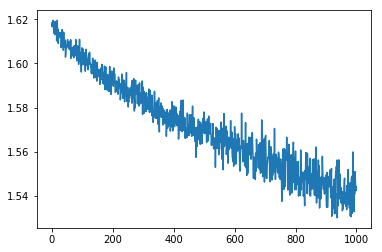

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
plt.figure()
plt.plot(all_losses)

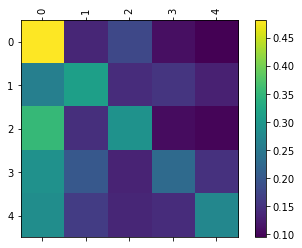

In [10]:
# Keep track of correct guesses in a confusion matrix
n_categories = 5
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()